In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Describes how to read the PDO time series from JISAO.  Data are read from http://research.jisao.washington.edu/pdo/PDO.latest.txt into a pandas dataframe.

In [2]:
import pandas as pd
import xarray as xr

import re
import glob
import os

Get OISSTv2 data

In [3]:
def get_oisst():
    
    SSTPATH = '/projects/arctic_scientist_data/NOAA_OISSTv2/sst/monthly'
    fileList = glob.glob( os.path.join( SSTPATH, 'sst.month.mean.????.v2.nc') )
    fileList.sort()
    #return fileList

    ds = xr.open_mfdataset(fileList, concat_dim='time')
    da = ds['sst'].load()
    ds.close()
    
    return da

def monAnom(x, year_begin='1981', year_end='2010'):
    """
    Calculates anomalies of x relative to the 1981-2010 period.

    N.B. Ideally, I would like to use an arbitrary mean field
    """
                                     
    def _anom(x):
        return x - x.sel(time=slice(year_begin,year_end)).mean(dim='time')

    return x.groupby('time.month').apply(_anom)


In [4]:
sst = get_oisst()

In [5]:
sstAnom = monAnom(sst)

In [6]:
sstAnom_neg = sstAnom.sel(time=slice('2008','2013')).mean(dim='time')
sstAnom_neg

<xarray.DataArray 'sst' (lat: 720, lon: 1440)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-0.055176, -0.055181, -0.055178, ..., -0.055166, -0.055158, -0.055154],
       [-0.054169, -0.054151, -0.054168, ..., -0.054125, -0.054142, -0.05415 ],
       [-0.053545, -0.053545, -0.053545, ..., -0.053541, -0.053543, -0.053543]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...

In [7]:
sstAnom_pos = sstAnom.sel(time=slice('2014','2017')).mean(dim='time')

In [11]:
def plot_sst_anomaly(sstAnom, loc, map_proj, extent, title='SST', add_colorbar=True, vmin=-2., vmax=2.):
    """
    Plots SST anomaly
    """
    ax = plt.subplot( loc, projection=map_proj )
    ax.set_extent( extent, ccrs.PlateCarree())
    if add_colorbar:
        cax = sstAnom.sel(lat=slice(30,90), lon=slice(90,270)).plot(ax=ax,
                                                                 transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, 
                                                                 cmap='coolwarm', 
                                                                 cbar_kwargs={'orientation': 'horizontal',
                                                                              'label': 'K'})
        cax.colorbar.set_label('K', size=20)
    else:
        cax = sstAnom.sel(lat=slice(30,90), lon=slice(90,270)).plot(ax=ax,
                                                                 transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, 
                                                                 cmap='coolwarm', 
                                                                 add_colorbar=False)
        
    ax.add_feature( cfeature.LAND )
    ax.gridlines( xlocs=[0,150,180,210,359], ylocs=[40,60,80], linestyles='dotted')
    ax.set_title(title, fontsize=20);
    ax.plot(-168.968, 66.338, 'yo', transform=ccrs.PlateCarree(), ms=7, markeredgecolor='k') # Location of A3

    return ax, cax

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

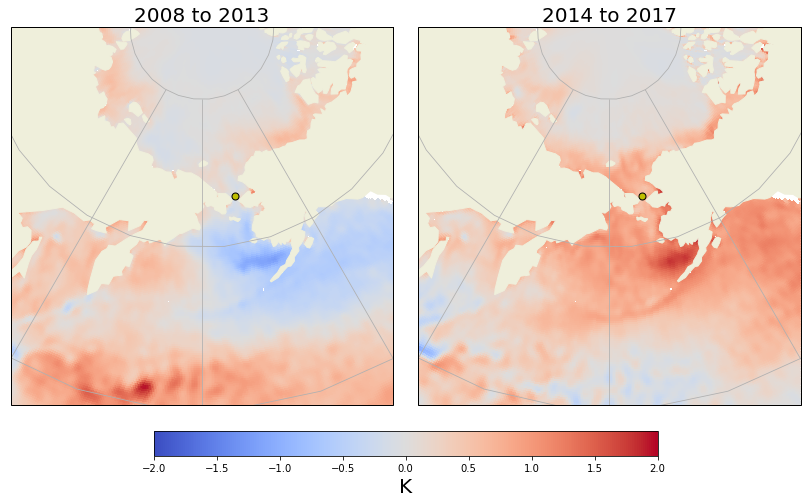

In [12]:
fig = plt.figure(figsize=(14, 7))
    
# Set up map projection and extent
map_proj = ccrs.NorthPolarStereo(central_longitude=180.)
extent = [150.,210.,40.,90.]
    
ax = []

ax1, im1 = plot_sst_anomaly(sstAnom_neg, 121, map_proj, extent, title='2008 to 2013', add_colorbar=False)
ax.append( ax1 )
ax2, im2 = plot_sst_anomaly(sstAnom_pos, 122, map_proj, extent, title='2014 to 2017', add_colorbar=False)
ax.append( ax2 )

fig.subplots_adjust(bottom=0.15, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.25, 0.05, 0.5, 0.05])
cbar = fig.colorbar(im1, cax=cb_ax, orientation='horizontal')
cbar.set_label('K', fontsize=20)

fig.savefig('pdo_phases_by_period.png')